In [2]:
using Pkg
Pkg.instantiate()
using HTTP, JSON, JLD, Roots, PrettyTables, DotEnv, Dates
DEBUG_LEVEL = 1
using Optim, Random
Random.seed!(0)
using BlackBoxOptim, Distributions, ForwardDiff, Integrals, Roots, StatsPlots, DelimitedFiles
cfg = DotEnv.config("../.env")
files_path = cfg["files_path"]

"/home/peters/code/mapinator/estimation/current_estimates_and_files/"

# Version 2

The second round is dropped in this version.  The unmatched are assumed to be all those in ocean and crow - reasoning is that they were matched with institutions that had no evidence that they participate on the international job market.

Change 2 - this no longer fully estimates the $\alpha_i$.  Instead (consistent with the idea that the unmatched are being recorded) each $m_i$ will be given by the column total from the adjusted adjacency matrix.  This means the estimated number of positions, or $n$ to be estimated. This is because
$$
\alpha_i = \frac{m_i}{n}
$$

In [3]:
# change associated with ocs as failed to trade group
raw_placement_rates = load(files_path*"adjusted_placement_rates.jld")["adjusted_placement_rates"]
unmatched_row_index = 10
adjusted_placement_rates = 
vcat(raw_placement_rates[1:unmatched_row_index-1,:],
raw_placement_rates[unmatched_row_index+1:size(raw_placement_rates)[1],:])
#adjusted_placement_rates = load(files_path*"adjusted_placement_rates.jld")["adjusted_placement_rates"]
# number of academic types
NUMBER_OF_TYPES = size(adjusted_placement_rates, 2)
# add unmatched to make and additional row
adjusted_placement_rates = vcat(adjusted_placement_rates, 
    raw_placement_rates[unmatched_row_index:unmatched_row_index, :])
# number of rows in the adj matrix
numtotal = size(adjusted_placement_rates, 1)

12

In [4]:
# this hack gets beliefs rho by setting it equal to the proportion of all placements
# used in estimation
function get_rho(adjusted_placement_rates)
    a = sum(adjusted_placement_rates, dims = 2)
    b = zeros(size(a)[1] - 1)
    for i in 1:size(a)[1]-1
        b[i] = a[i]
    end
    B = sum(b)
    return b = b./B
end

get_rho (generic function with 1 method)

In [8]:
#setup stuff
k = NUMBER_OF_TYPES
# number of recruiter types, note this is one less that the number of rows in the adjacency matrix
K = numtotal-1
## sample size for computed expectations
M = sum(adjusted_placement_rates)
# need the column sums to calculate \alpha
workers = sum(adjusted_placement_rates, dims= 1)
#maximum likelihood  true for ML false for chi-squared
L = true
#chi-squared
#L = false

# upper bound on the value ratios, which should all be less than 1
# if any ratio turns out to be 1.0 or close to it at optimality, this could indicate that a lower tier has a higher value than a higher one
search_range = Tuple[]
for i in 1:k-1
    push!(search_range, (0.0, 1.0))
end

# upper bound on variables proportionate to alpha
push!(search_range, (Float64(sum(workers)), Inf))

# upper bound on the mu parameter of truncated normal, which is strictly within [0, 1] as the mean is greater than mu in truncated normal

for i in k+1:k+K
    push!(search_range , (.1,1.0))
end

# upper bound on the sigma parameter of truncated normal
for i in k+K+1:k+2K
    push!(search_range , (.1,5.0))
end

# these are parameters that generate beliefs, not the beliefs themselves
#for i in k+2K+1:k+3K
#   push!(search_range , (.1,1.))
#end


In [9]:
println(search_range)
size(search_range)

Tuple[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (27489.0, Inf), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0)]


(27,)

In [12]:
function F(x, ρ, μ, σ, K)
    return sum([ρ[i] * cdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function f(x, ρ, μ, σ, K)
    return sum([ρ[i] * pdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function G(Fim1, Fx, αsum)
    return (Fim1 - Fx) / αsum
end

function κ(i, t, v_rel)
    return sum([-log(v_rel[j]) for j in t:i-1])
end

function fi(x, μ, σ)
    return pdf(truncated(Normal(μ, σ), 0, 1), x)
end

fi (generic function with 1 method)

In [11]:
function q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    # TODO: can some integrals be cached as a speed-up? can some integrals be computed in parallel?
    return sum([(α[t]/sum(α[1:s])) * 
            solve(IntegralProblem{false}((x, p) -> exp(-(G(Fx_vec[s], F(x, ρ, μ, σ, K), sum(α[1:s])) + κ(s, t, v_rel))) *
                    fi(x, μ[i], σ[i]), x_vec[s+1], x_vec[s]), HCubatureJL())[1] for s in t:k])
end

function Fx(t, α, v_rel)
        return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function Q2(ratio, β)
    return β * (1 - exp(-ratio)) / ratio
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

pi (generic function with 1 method)

In [40]:
"""
Likelihood
    p_vec -> k values,k alpha shares, K means, K variances, K beliefs
    example -  for 5 academic tiers and six hiring tiers p_vec has 43 elements
    - it assumes the last row of the adjacency matrix is for unmatched so the placement matrix in the example has dimension 12x5 not 11x5
    placements -> the adjacency matrix with the unmatched row moved to the bottom
    k -> number of academic tiers
    K -> rows in the adjacency matrix - last row is treaed as unmatched
    L -> true for likelihood, false for chi-squared maximization
"""
function estimate_likelihood(p_vec, placements, k, K, M, L)
    #values
    v_rel = p_vec[1:k-1]
    #println(v_rel)
    #shares
    α = []
    for i in 1:k
        push!(α, workers[i]/p_vec[k])
    end
    #means
    #println(α)
    μ = p_vec[k+1:k+K]
    #variances
    #println(μ)
    σ = p_vec[k+K+1:k+2K]
    #println(σ)
    #setting rho exogenously
    ρ = get_rho(placements)
    #ρ = a
      # println(sum(ρ))
    #β = p_vec[end] # set = 1 to hardcode
    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        #println(v_rel[t], " ", -log(v_rel[t])*sum(α[1:t]))
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        if  Fx_vec[t+1] > 0 && Fx_vec[t+1] < 1
            x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5)
        else
            x_vec[t+1] = 1
        end
    end    
    #println(Fx_vec)
    #println(x_vec)
    objective = 0.0
    o = 0.0
    likelihood = 0.0
    normalizer = zeros(k)
    # recode
    # 1-normalizer is now the probabiity a placement should end up in ocs  
    q_it = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
        q_it[i, t] = prob
        normalizer[t] += ρ[i] * prob
    end
    #println(normalizer)
    #println(sum(normalizer))
    for i in 1:K, t in 1:k 
        expectation = M * ρ[i] * q_it[i, t] + .5
        #println(expectation, " ", placements[i,t], " ",expectation-placements[i,t])
        if L
            # likelihood
            objective += placements[i, t] * (log(ρ[i] * (q_it[i, t] ) + .5))
            objective -= log(factorial(big(placements[i, t])))
        else
            objective += (placements[i, t] - expectation) ^ 2 / expectation
        end
    end
    for t in 1:k
        expectation = M*(1-normalizer[t])
        #println(placements[K+1,t], " ", expectation, " ", placements[K+1,t]-expectation)
        #println(1-normalizer[t])
        if L
            ##objective += placements[K+1, t]*log(1 - normalizer[t])
            ##objective -= log(factorial(big(placements[K+1, t])))
        else
           # println(placements[K+1, t])
           # println(expectation)
           # println((placements[K+1, t] - expectation)^2 / expectation)
            ##objective = o + (placements[K+1, t] - expectation)^2 / expectation
           # println(o)
        end
    end
    if L
        return Float64(-objective)
    else 
        return Float64(objective)
    end
end


estimate_likelihood

In [41]:
v = [.68, .75, .75, .75] 
num = sum(workers)
mu = [.88,.5, .4, .2, .05, .3, .8, .1, .3, .1, .1]
sigma = [.3,.4, .5,.6,.7,.8,1,1.1,1.3,.1,.9]
trial = vcat(v,num,mu,sigma)
soln = estimate_likelihood(trial, adjusted_placement_rates, k, K, M, false)

15893.804719452983

In [45]:

# all lower bounds are zero as these should be positive parameters
# can swap estimate_likelihood for chi_square
println(k, " ",K," ",M)
sol_res = bboptimize(p -> estimate_likelihood(p, adjusted_placement_rates, k, K, M, false),
    SearchRange = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (27489.0, 100000), 
        (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), 
        (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 1.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), 
        (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0), (0.1, 5.0),
        (0.1, 5.0)], 
    MaxFuncEvals = 100000, TraceInterval = 5)
sol = best_candidate(sol_res)

5 11 27489
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.00 secs, 1110 evals, 1009 steps, improv/step: 0.408 (last = 0.4083), fitness=11138.924907142
10.00 secs, 2134 evals, 2033 steps, improv/step: 0.356 (last = 0.3037), fitness=9547.521925793
15.01 secs, 3056 evals, 2955 steps, improv/step: 0.326 (last = 0.2603), fitness=9090.007558240
20.01 secs, 3932 evals, 3831 steps, improv/step: 0.300 (last = 0.2112), fitness=8400.940285139
25.01 secs, 4806 evals, 4705 steps, improv/step: 0.284 (last = 0.2174), fitness=8204.975331792
30.01 secs, 5663 evals, 5562 steps, improv/step: 0.267 (last = 0.1727), fitness=7721.659195634
35.02 secs, 6540 evals, 6439 steps, improv/step: 0.254 (last = 0.1676), fitness=7414.879822407
40.02 secs, 7465 evals, 7364 steps, improv/step: 0.243 (last = 0.1697), fitness=7007.212034634
45.02 secs, 8430 evals, 8

27-element Vector{Float64}:
     0.649160719515115
     0.7890555127516253
     0.7605267007770308
     0.7073829444863476
 27489.000000104705
     0.9999999999221887
     0.6190414184135133
     0.538165682189674
     0.36963627595353016
     0.10000000003760226
     0.5622104256596914
     0.9999999934271504
     0.25472475787517607
     ⋮
     0.30873318493773433
     0.38305303359102727
     0.21165570705518483
     0.15935186747762892
     0.10000000000727163
     0.10000000000661478
     0.2406429522555927
     1.0900304929910782
     0.22017821222223635
     0.10000000001134031
     0.3592626927755306
     0.17562018962681572

In [46]:
s = best_candidate(sol_res)

27-element Vector{Float64}:
     0.649160719515115
     0.7890555127516253
     0.7605267007770308
     0.7073829444863476
 27489.000000104705
     0.9999999999221887
     0.6190414184135133
     0.538165682189674
     0.36963627595353016
     0.10000000003760226
     0.5622104256596914
     0.9999999934271504
     0.25472475787517607
     ⋮
     0.30873318493773433
     0.38305303359102727
     0.21165570705518483
     0.15935186747762892
     0.10000000000727163
     0.10000000000661478
     0.2406429522555927
     1.0900304929910782
     0.22017821222223635
     0.10000000001134031
     0.3592626927755306
     0.17562018962681572

In [50]:
"""
    sol -> the solution provided by bboptimize
    placements ->   the actual placements including unmatched dimensions computer from the size of this matrix
"""
function print_solution(sol_res, placements, workers) 
    k = size(placements)[2]
    K = size(placements)[1]-1
    M = sum(placements)
    sol = best_candidate(sol_res)
    println("fitness = ", best_fitness(sol_res))
    println()
    println("Values:")
    println("  Tier 1: ", 1)
    start = 1
    for i in 1:k-1
        start = start*sol[i]
        println("  Tier_", 1+i, " : ", start)
    end
    println()
    println("Estimated Demand: ", sol[k])
    println("Shares (alpha - commputed  directly from placements)")
    for i in k+1:2k
        println("  Tier_", i-k, " : ", workers[i-k]/sol[k])
    end
    hiring_data = zeros(K,2)
    for i in 1:K
        hiring_data[i,1] = sol[k+i]
        hiring_data[i,2] = sol[k+K+i]

    end
    display(hiring_data)
   return hiring_data
end

print_solution

In [51]:
hiring_data = print_solution(sol_res,adjusted_placement_rates, workers);

fitness = 5415.940778828727

Values:
  Tier 1: 1
  Tier_2 : 0.649160719515115
  Tier_3 : 0.5122238443952131
  Tier_4 : 0.3895599104372186
  Tier_5 : 0.2755680364989176

Estimated Demand: 27489.000000104705
Shares (alpha)
  Tier_1 : 0.2479901051320177
  Tier_2 : 0.28211284513698065
  Tier_3 : 0.2555931463484753
  Tier_4 : 0.14143839353869514
  Tier_5 : 0.07286550984002221


11×2 Matrix{Float64}:
 1.0       0.383053
 0.619041  0.211656
 0.538166  0.159352
 0.369636  0.1
 0.1       0.1
 0.56221   0.240643
 1.0       1.09003
 0.254725  0.220178
 0.1       0.1
 0.509403  0.359263
 0.308733  0.17562

In [60]:
classification_properties = load(files_path*"classification_properties.jld")["classification_properties"]
a = classification_properties["institution_counts"]
norm = []
for b in a
    push!(norm, b/sum(a))
end
norm

12-element Vector{Any}:
 0.005924170616113744
 0.018364928909952605
 0.05302132701421801
 0.10426540284360189
 0.16824644549763032
 0.047097156398104266
 0.07553317535545023
 0.18809241706161137
 0.13122037914691942
 0.0002962085308056872
 0.0115521327014218
 0.1963862559241706

In [14]:
save(files_path*"current_estimates.jld", "all_data", all_data)

In [15]:
open(files_path*"current_estimates.tex", "w") do f
pretty_table(
    f,
    all_data',
    header = head,
        row_labels = row_names,
    backend = Val(:latex)
    )
end

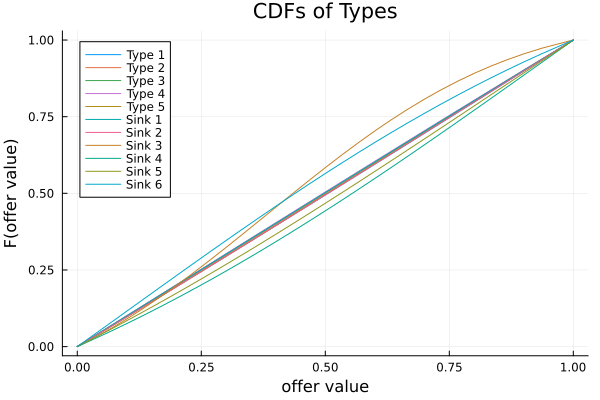

In [16]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/

select_type = 1
cdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Sink ", select_type - k))
end
xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
savefig(cdfs, "cdfs.png")
cdfs

In [17]:
expected_offers = []
for select_type in 1:K
     push!(expected_offers,mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
end
expected_offers
save(files_path*"expected_offers.jld", "expected_offers", expected_offers)

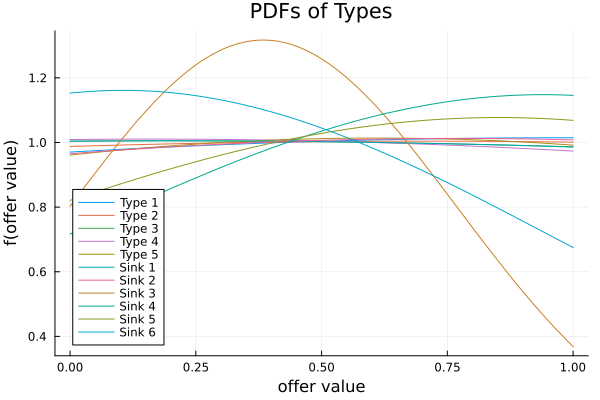

In [18]:
select_type = 1
pdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:k # academic types
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, 
        label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, label = string("Sink ", select_type - k))
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
savefig(pdfs, "pdfs.png")